Dropped missing: None!
(2229, 6)
date      datetime64[ns]
price            float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object


C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='date', ylabel='price'>

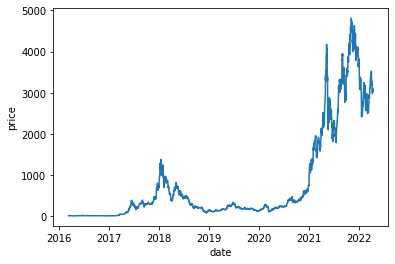

In [106]:
import import_ipynb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import plotly.graph_objects as go

df = pd.read_csv(r"F:\Obboy\trade_sim\ethdata_apr22.csv", parse_dates=True)
df.rename(columns={"Date":"date", "Open": "price"}, inplace=True)

#Make some formatting changes
df.date = pd.to_datetime(df['date'], infer_datetime_format = True, format = '%y-%m-%d')
df.sort_values(by=['date'], inplace=True)


# Drop with missing values
prev_len = df.shape[0]
df.dropna(inplace =True)
print("Dropped missing:", prev_len-df.shape[0] if (prev_len-df.shape[0]) > 0 else "None!")

print(df.shape)
print(df.dtypes)
df.tail()
sns.lineplot(df.date, df.price)

# Buy 7-day put Hegic option

Pay option price @ 5% of strike price.
Assuming at the money option, strike price = market price at buy.
Buys at time = t1.
Assuming fixed expiry date of te.
Sells at time = t1 + te.
Since buying put option, profit is strike price - lower price where we buy up.
Assume we buy when price hits strike price - 10% to make 5% profit.

profit calculation = (0.95 - k) * buy_price * buy_amount
    where k = new_price/buy price




In [109]:
# We will buy a 7-day put option everyday and exercise as soon as 2% can be profited
# Assuming an option price of 5%

def buy_put (put_up, period, time_start, start_price, profit_pcnt):
    option_price = 0.05
    time_expiry = time_start + datetime.timedelta(period)
    
    # Pull out as soon as profit threshold reached
    pull_out = 1 - option_price - profit_pcnt

    underlying_initial = put_up / option_price
    start_price = df.loc[df['date'] == time_start, 'price'].iloc[0]
    start_amount = underlying_initial/start_price
    
    # Pull out price when date inside option period and price reaches pull out level
    # Return loss if no suitable price
    try:
        new_price = df.loc[(df['price'] < (start_price*pull_out)) & (df.date>=time_start) & (df.date<time_expiry), 'price'].iloc[0]
    except:
        return (put_up*-1)
    
    k = new_price/start_price

    profit = (pull_out - k) * start_price * start_amount
    
#    print("buy day:", time_start, "sell day:", time_expiry)
#    print("buy:", new_price, "sell:", start_price, "amount:", start_amount, "to profit:", profit)
    return profit if profit > (put_up * -1) else 0

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14292\2849823264.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In 2229 days, we can exercise option in 844 days and make pnl of -73596.92000000011


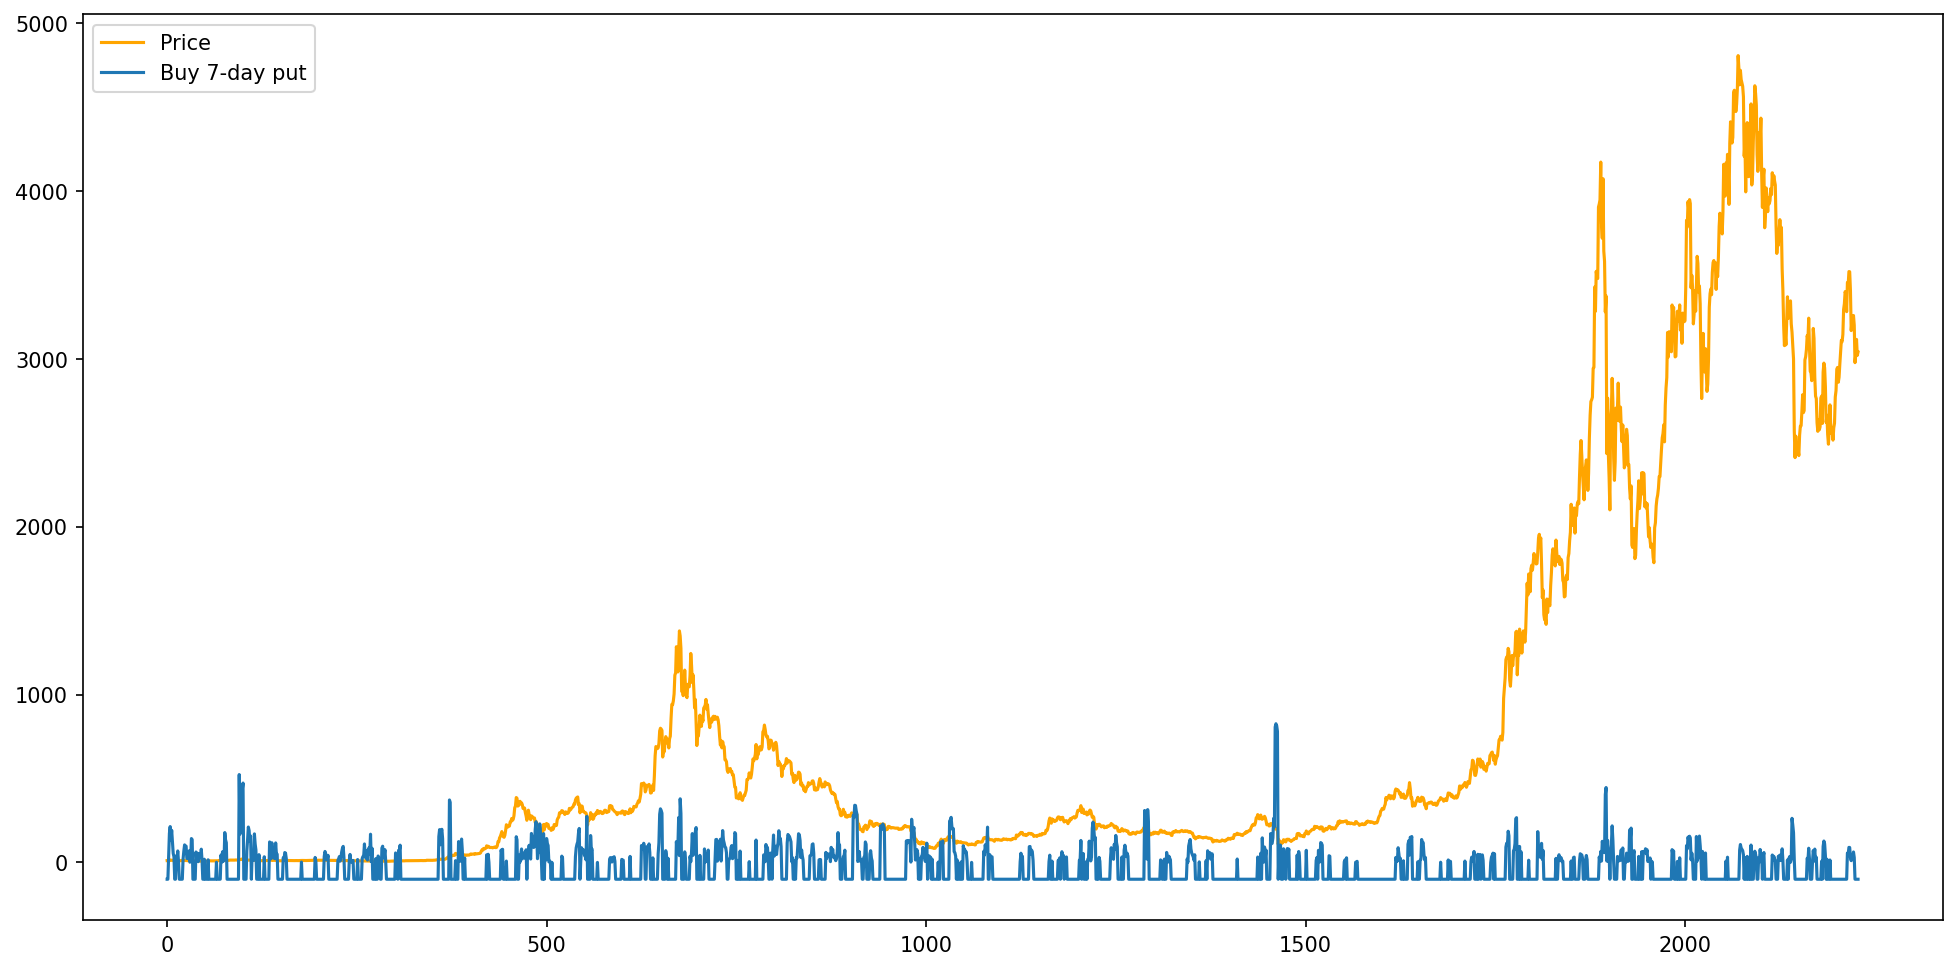

In [110]:
df['buy_put_7'] = 0
cumulative_pnl = 0
exercise = 0

for i in df.index:
    # HERE WE SET THE PARAMETERS AND RUN THE STRATEGY
    daily_pnl = round(buy_put(100, 7, df['date'][i], df['price'][i], 0.005),2)
    df['buy_put_7'][i] = daily_pnl
    cumulative_pnl += daily_pnl 
    exercise += 1 if (daily_pnl > 0) else 0
    
print(f"In {len(df)} days, we can exercise option in {exercise} days and make pnl of {cumulative_pnl}") 

df.set_index('date')

# Plot against ETH prices
plt.figure(figsize=(16, 8), dpi=150)
df['price'].plot(label="Price", color='orange')
df['buy_put_7'].plot(label="Buy 7-day put")
plt.legend()

# Buy 7-day call option Hegic

 - Assuming strike price = market price at start
 - Can sell when price > start price
 - profit is the difference minus option premium

In [111]:
def buy_call (put_up, period, time_start, start_price, profit_pcnt):
    option_price = 0.05
    time_expiry = time_start + datetime.timedelta(period)
    
    # Pull out as soon as profit threshold reached
    pull_out = 1 + option_price + profit_pcnt

    underlying_initial = put_up / option_price
    start_amount = underlying_initial/start_price
    
    # Pull out price when date inside option period and price reaches pull out level
    # Return loss if no suitable price
    try:
        new_price = df.loc[(df['price'] > (start_price*pull_out)) & (df.date>=time_start) & (df.date<time_expiry), 'price'].iloc[0]
    except:
        return (put_up*-1)

    profit = ((new_price-start_price) * start_amount) - put_up
    
#    print("buy day:", time_start, "sell day:", time_expiry)
#    print("buy:", new_price, "sell:", start_price, "amount:", start_amount, "to profit:", profit)
    return profit if profit > (put_up * -1) else 0

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14292\2226864475.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In 2229 days, we can exercise option in 1008 days and make pnl of -20410.010000000002


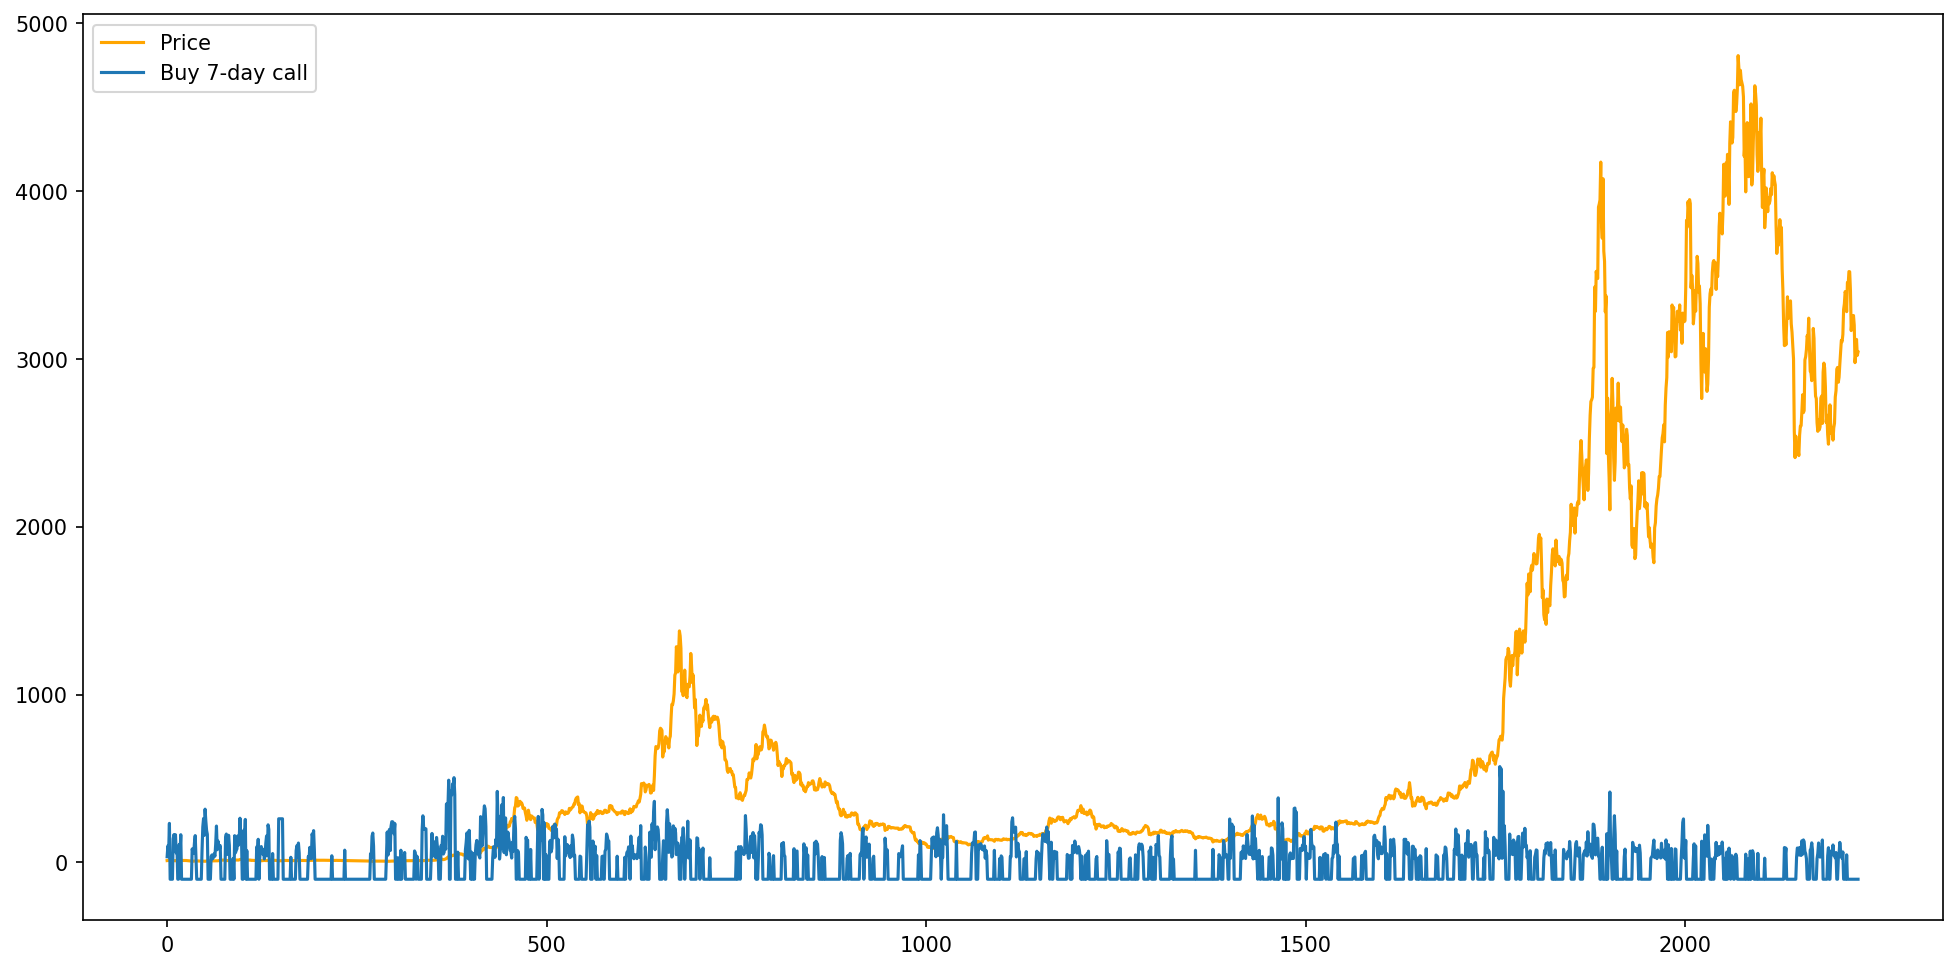

In [112]:
df['buy_call_7'] = 0
cumulative_pnl = 0
exercise = 0

for i in df.index:
    # HERE WE SET THE PARAMETERS AND RUN THE STRATEGY
    daily_pnl = round(buy_call(100, 7, df['date'][i], df['price'][i], 0.01),2)
    #print("profit:", daily_pnl)
    df['buy_call_7'][i] = daily_pnl
    cumulative_pnl += daily_pnl 
    exercise += 1 if (daily_pnl > 0) else 0
    
print(f"In {len(df)} days, we can exercise option in {exercise} days and make pnl of {cumulative_pnl}") 

df.set_index('date')

# Plot against ETH prices
plt.figure(figsize=(16, 8), dpi=150)
df['price'].plot(label="Price", color='orange')
df['buy_call_7'].plot(label="Buy 7-day call")
plt.legend()

In [113]:
# Assuming no platform fees, profit of sellers is equal to loss of buyers

df['sell_call_7'] = df['buy_call_7'] * -1
df['sell_put_7'] = df['buy_put_7'] * -1

print("Sell-side call cumulative PNL:", df['sell_call_7'].sum())
print("Sell-sidde put cumulative PNL:", df['sell_put_7'].sum())

Sell-side call cumulative PNL: 20410.009999999995
Sell-sidde put cumulative PNL: 73596.92000000001


# Mean Reversion
Now, we can attempt to improve our buying decisions using simple Mean Reversion


In [151]:
ma = 7
df['ma'] = df['price'].rolling(ma).mean()
df['ratio'] = df['price']/df['ma']
df.ratio.describe()

count    2223.000000
mean        1.008537
std         0.077507
min         0.544284
25%         0.969052
50%         1.004133
75%         1.046817
max         1.572653
Name: ratio, dtype: float64

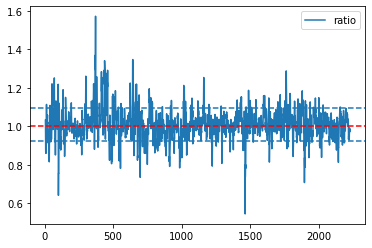

In [152]:
percentiles = [5, 10, 50, 90, 95]
p = np.percentile(df['ratio'].dropna(), percentiles)
df['ratio'].dropna().plot(legend=True)
plt.axhline(p[1], ls='--')
plt.axhline(p[2], color="red", ls='--')
plt.axhline(p[3], ls='--')

<AxesSubplot:>

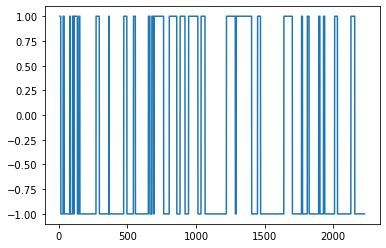

In [117]:
# Go short if price exceeds 90th percentile
short = p[3]

# Go long if price goes below 10th percentile
long = p[0]

df['position'] = np.where(df.ratio>short, -1, np.nan)
df['position'] = np.where(df.ratio<long, 1, df['position'])
df['position'] = df['position'].ffill()
df['position'].dropna().plot()

Mean reverting buy-only cumulative PNL: -25220.989999999998


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14292\1959437483.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



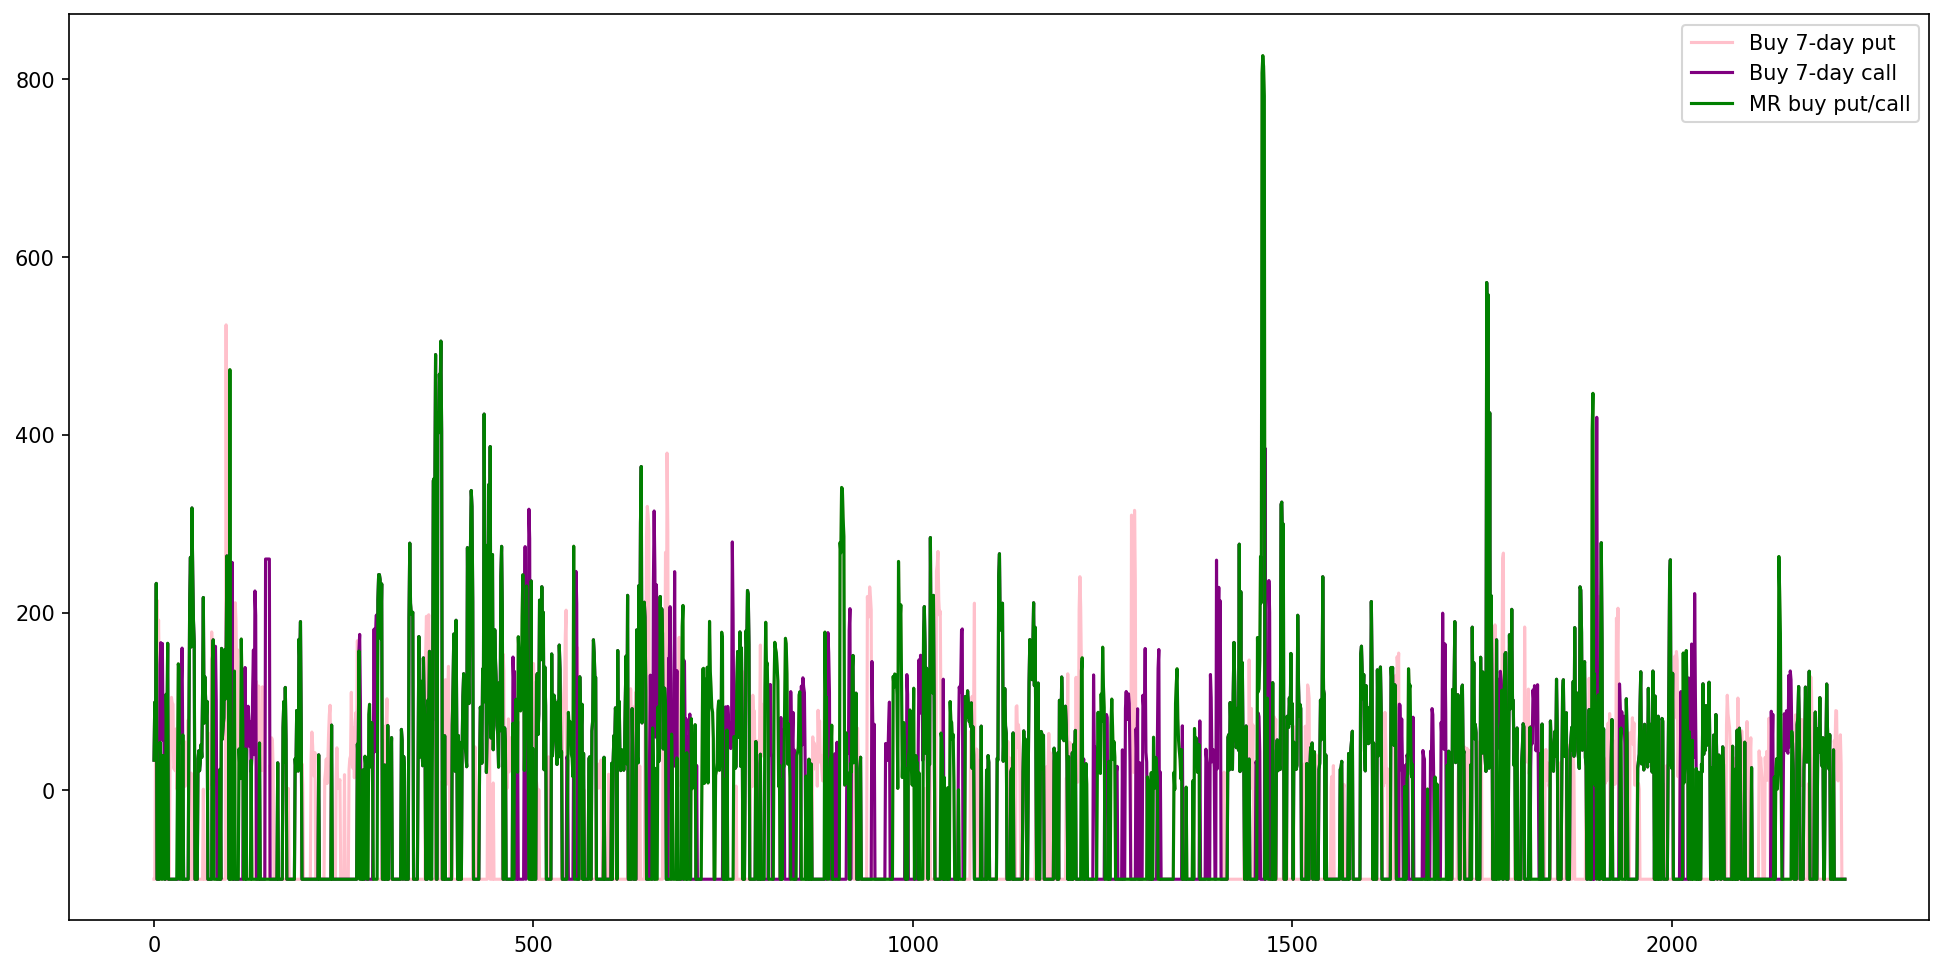

In [118]:
df['mr_buy'] = 0
for i in df.index:
    df['mr_buy'][i] = df['buy_put_7'][i] if df['position'][i]==1 else df['buy_call_7'][i]
    
print("Mean reverting buy-only cumulative PNL:", df['mr_buy'].sum())

# Plot against blind buy strategies
plt.figure(figsize=(16, 8), dpi=150)

df['buy_put_7'].plot(label="Buy 7-day put", color="pink")
df['buy_call_7'].plot(label="Buy 7-day call", color="purple")
df['mr_buy'].plot(label="MR buy put/call", color='green')
plt.legend()

In [153]:
# Creating week and month numbers to de-clutter plot

df.sort_values(by=['date'],inplace=True)
df['week'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year - 2016
df['week'] += df['year'] * 48
df['month'] += df['year'] * 12

df_weeks = df.groupby(['week'])[['mr_buy','buy_call_7','buy_put_7']].sum()
df_months = df.groupby(['month'])[['mr_buy','buy_call_7','buy_put_7']].sum()
df_months.head()

,mr_buy,buy_call_7,buy_put_7
month,,,
3,-202.33,558.64,206.53
4,-369.01,-19.60,377.41
5,311.90,1089.35,-1517.47
6,554.01,480.97,1358.98
7,-1773.16,131.74,-420.02


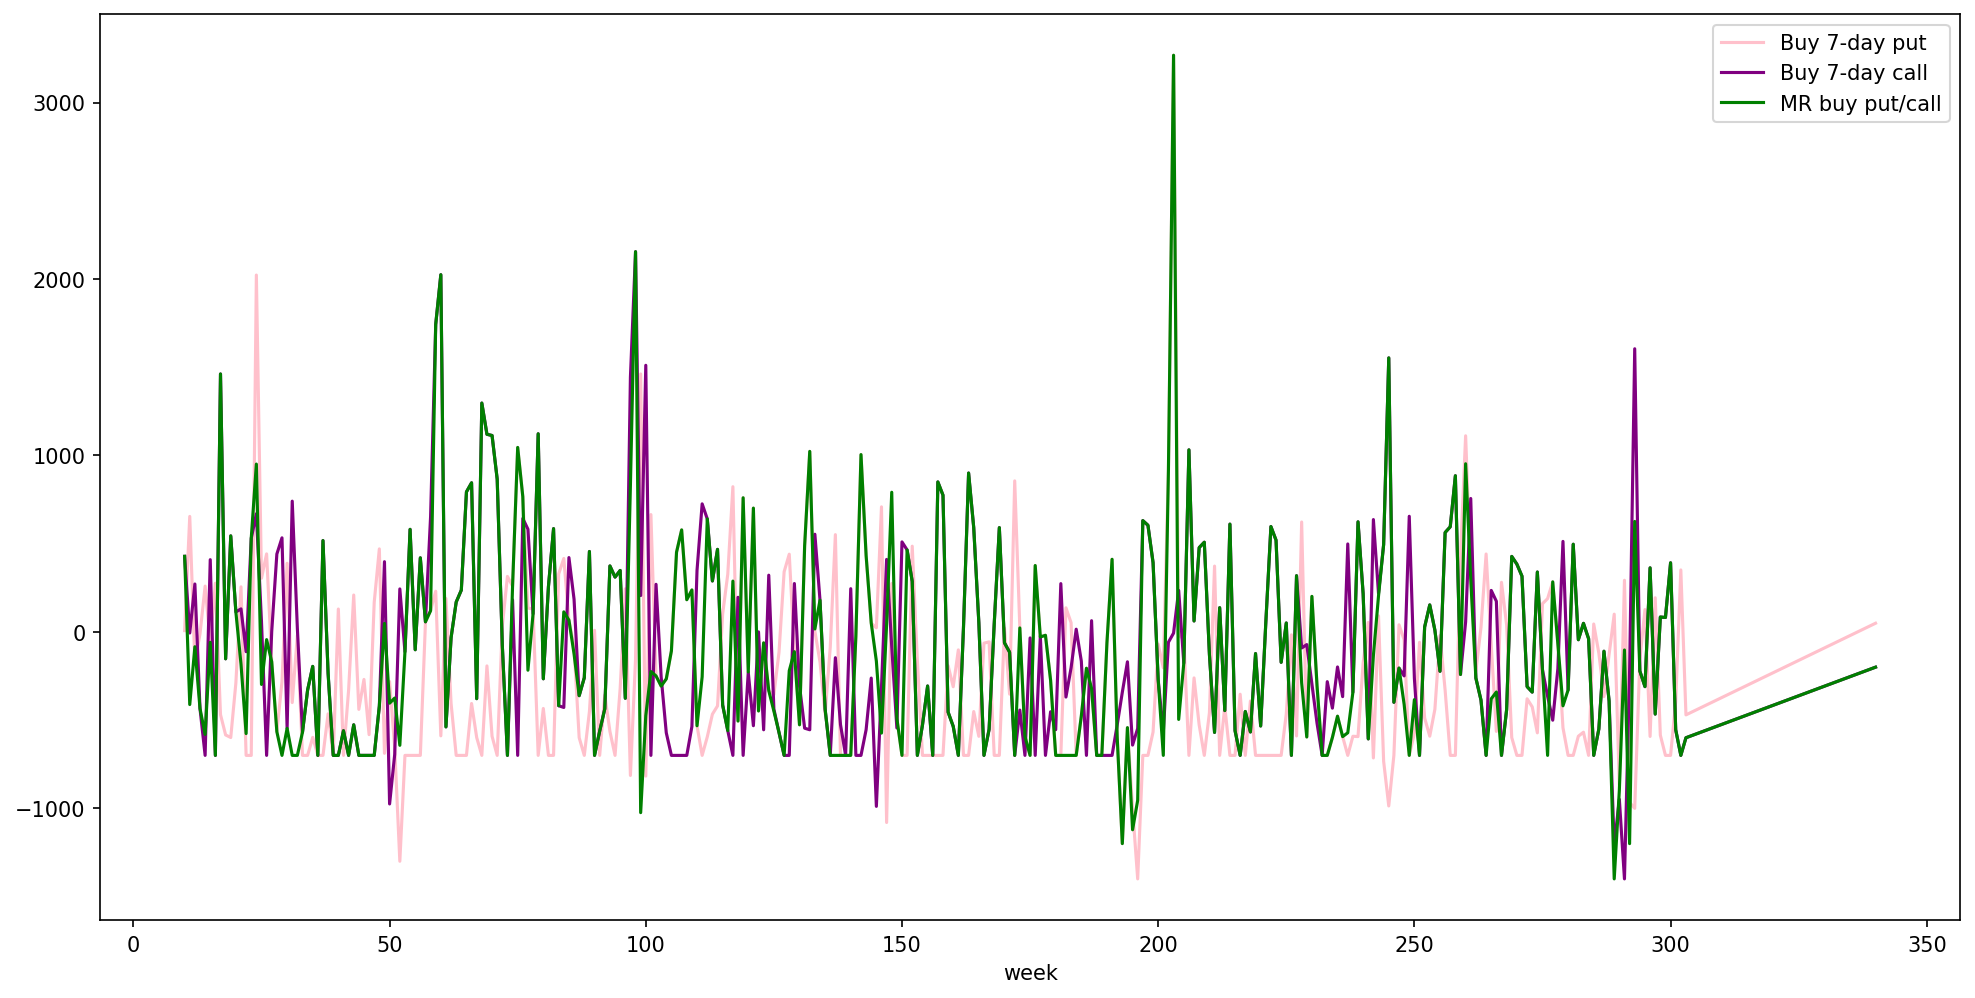

In [154]:
# Replotting over weeks
plt.figure(figsize=(16, 8), dpi=150)
df_weeks['buy_put_7'].plot(label="Buy 7-day put", color="pink")
df_weeks['buy_call_7'].plot(label="Buy 7-day call", color="purple")
df_weeks['mr_buy'].plot(label="MR buy put/call", color='green')
plt.legend()

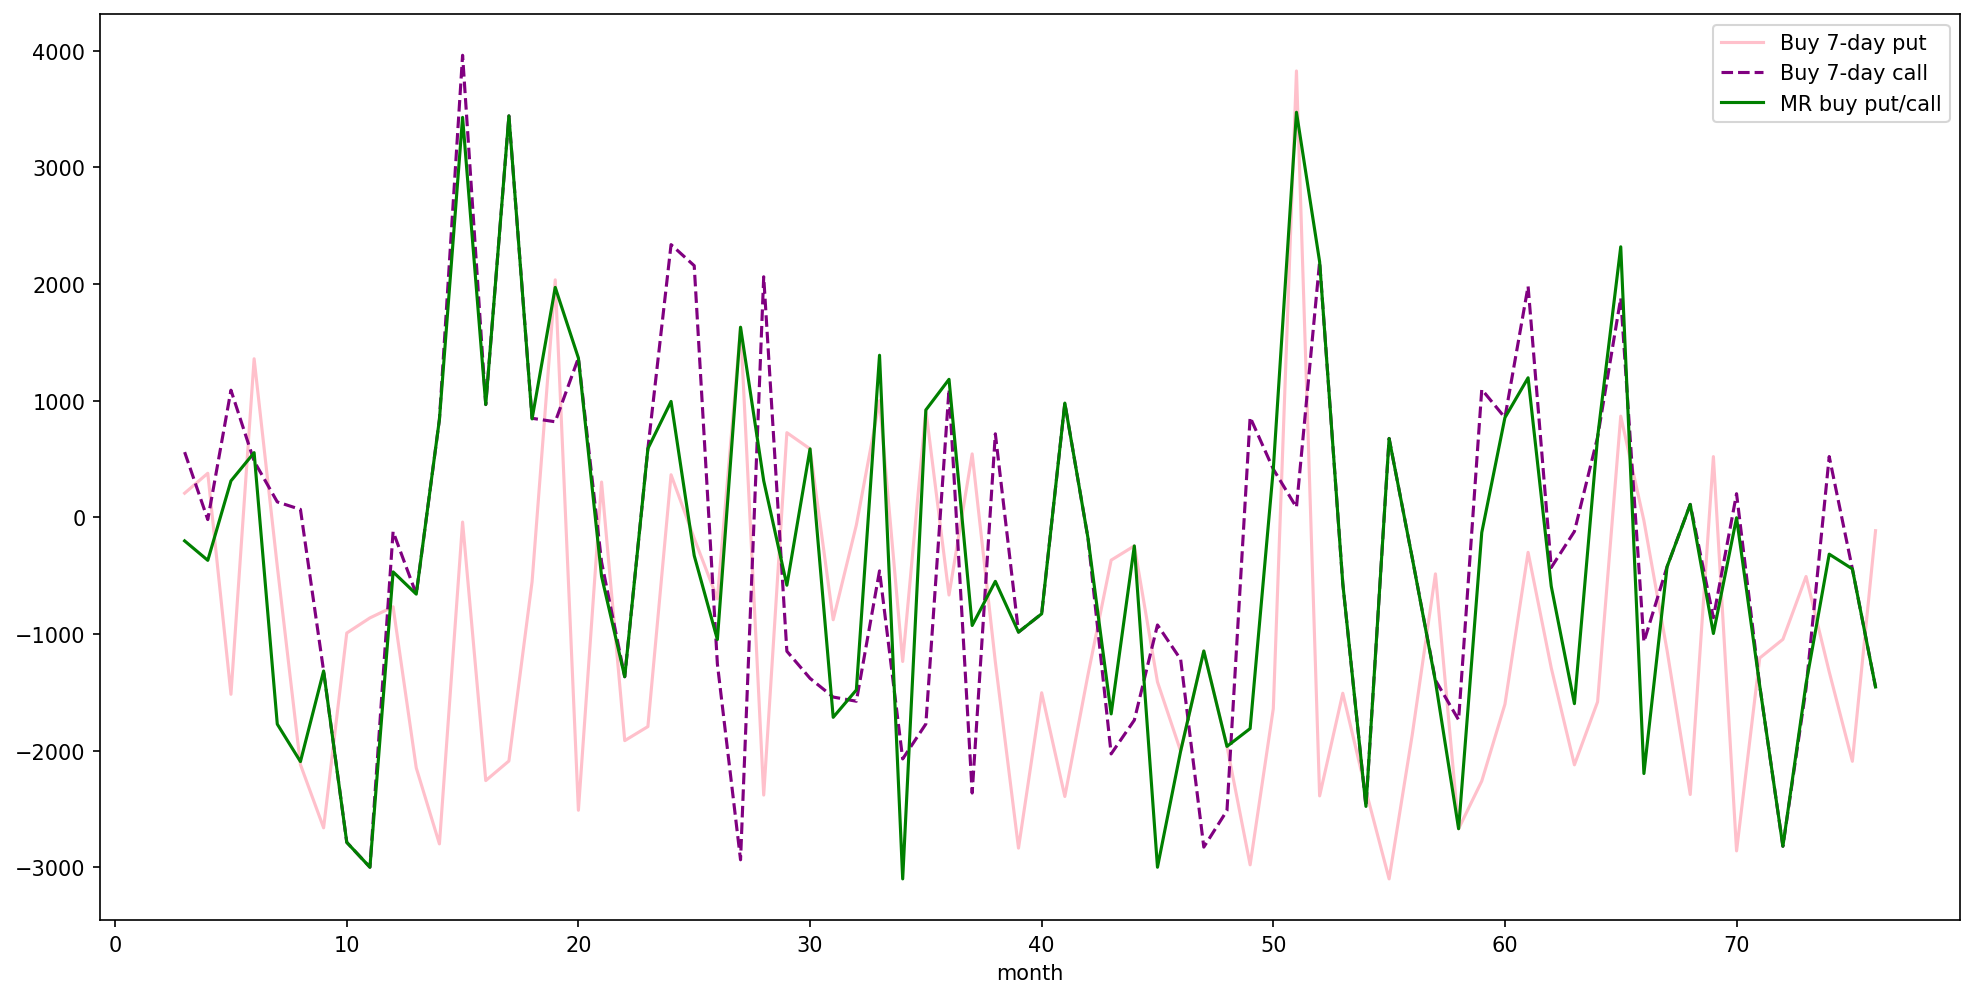

In [156]:
# Replotting over months
plt.figure(figsize=(16, 8), dpi=150)
df_months['buy_put_7'].plot(label="Buy 7-day put", color="pink")
df_months['buy_call_7'].plot(label="Buy 7-day call", color="purple", linestyle='dashed')
df_months['mr_buy'].plot(label="MR buy put/call", color='green')
plt.legend()